Best objective: 80Minimum objective: 80
Rashomon set size: 33
Histogram entries: [(80, 12), (81, 8), (82, 5), (84, 8)]
Objective = 80, Count = 12
Objective = 81, Count = 8
Objective = 82, Count = 5
Objective = 84, Count = 8

Total Rashomon trees: 33

Tree 0
Objective (raw):      80
Objective (normalized): 0.080000

Predictions from tree 0 (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]

Tree 0 has 8 leaves.
All root-to-leaf paths:
[+2, +3, +14] -> 0
[+2, +3, -14] -> 1
[+2, -3, +14] -> 1
[+2, -3, -14] -> 0
[-2, +3, +14] -> 1
[-2, +3, -14] -> 0
[-2, -3, +14] -> 0
[-2, -3, -14] -> 1
 (0.08)
Objective bound: 84
Minimum objective: 80
Cache sizes - Greedy: 12302, Lickety: 778, Trie: 0, Trie cache: OFF


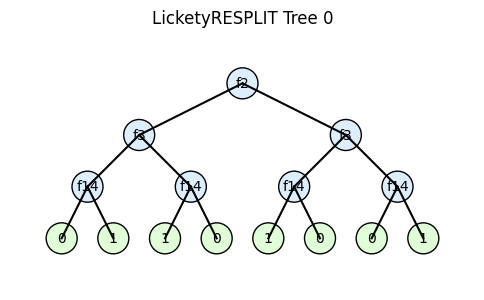

<Figure size 640x480 with 0 Axes>

Tree 32
Objective (raw):      84
Objective (normalized): 0.084000

Predictions from tree 32 (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]

Tree 32 has 8 leaves.
All root-to-leaf paths:
[+14, +3, +12] -> 0
[+14, +3, -12] -> 1
[+14, -3, +2] -> 1
[+14, -3, -2] -> 0
[-14, +3, +2] -> 1
[-14, +3, -2] -> 0
[-14, -3, +2] -> 0
[-14, -3, -2] -> 1


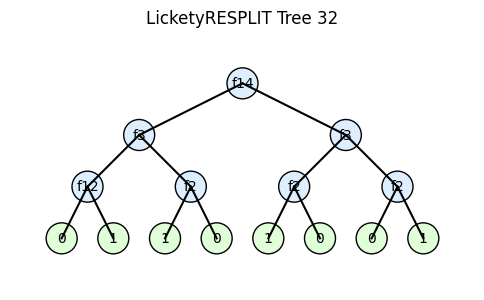

<Figure size 640x480 with 0 Axes>


[Dimensionality] Number of trees in all_preds_list: 33
[Dimensionality] Shape of first tree's prediction vector: (1000,)

[Dimensionality] Stacked prediction matrix shape (n_trees, n_samples): (33, 1000)
Majority-vote predictions (first 10 samples):
[1 0 0 0 0 0 1 1 1 1]


In [6]:
import numpy as np
from licketyresplit import LicketyRESPLIT
import matplotlib.pyplot as plt

n_samples = 1000
n_features = 10

rng = np.random.default_rng(0)

X = (rng.random((n_samples, n_features)) > 0.5).astype(np.uint8)

# label: odd/even parity of first 4 features
three_sum = X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3]
y = (three_sum % 2).astype(int)

# extra feature for interest: 1 if x1 + x2 is even, 0 otherwise
sum_01 = X[:, 0] + X[:, 1]
even_01 = ((sum_01 % 2) == 0).astype(np.uint8)

# make 4 noisy copies of the first 4 columns
# each entry is flipped with probability 1/100
base_four = X[:, :4].copy()
flip_mask = (rng.random((n_samples, 4)) < 0.01).astype(np.uint8)  # 1 with prob 0.01, else 0
noisy_four = base_four ^ flip_mask  # XOR to flip bits where flip_mask == 1

# append these extra features
X = np.hstack([X, noisy_four, even_01[:, None]])


model = LicketyRESPLIT()

model.fit(
    X, y,
    lambda_reg=0.01,        # sparsity penalty - recommended
    depth_budget=5,         # max tree depth as defined by number of splits along any path
    rashomon_mult=0.05,     # rashomon bound: 5% worse than initial oracle objective
    # optional parameters (default is sufficient)
    multiplicative_slack=0, # extra slack factor 
    key_mode="hash",        # "hash" for memory savings at an astronomically low change of error or "exact"
    trie_cache_enabled=False, # not recommended with hash
    lookahead_k=1, # 1 = LicketySPLIT oracle, 0 = greedy, >1 higher-tiered oracles
)

print("Minimum objective:", model.get_min_objective())
print("Rashomon set size:", model.count_trees())

hist = model.get_root_histogram()
print("Histogram entries:", hist)

for obj, cnt in hist:
    print(f"Objective = {obj}, Count = {cnt}")

# we will inspect the first and last trees
num_trees = model.count_trees()
tree_indices = [0, num_trees - 1]

print(f"\nTotal Rashomon trees: {num_trees}\n")

for tree_idx in tree_indices:
    print("=" * 60)
    print(f"Tree {tree_idx}")
    
    obj_raw, obj_norm = model.get_tree_objective(tree_idx)
    print(f"Objective (raw):      {obj_raw}")
    print(f"Objective (normalized): {obj_norm:.6f}")

    preds_i = model.get_predictions(tree_idx, X)
    print(f"\nPredictions from tree {tree_idx} (first 10 samples):")
    print(preds_i[:10])

    paths_str, preds = model.get_tree_paths_str(tree_idx)
    print(f"\nTree {tree_idx} has {len(paths_str)} leaves.")

    print("All root-to-leaf paths:")
    for s, p in zip(paths_str, preds):
        print(s, "->", p)

    fig, ax = plt.subplots(figsize=(6, 4))
    model.plot_tree(tree_idx, ax=ax)
    ax.set_title(f"LicketyRESPLIT Tree {tree_idx}")
    plt.tight_layout()
    plt.show()
    
# list-of-vectors version
all_preds_list = model.get_all_predictions(X, stack=False)
print(f"\n[Dimensionality] Number of trees in all_preds_list: {len(all_preds_list)}")
if len(all_preds_list) > 0:
    print("[Dimensionality] Shape of first tree's prediction vector:",
          all_preds_list[0].shape)

# stacked matrix version
all_preds_mat = model.get_all_predictions(X, stack=True)
print("\n[Dimensionality] Stacked prediction matrix shape (n_trees, n_samples):",
      all_preds_mat.shape)

majority_vote = (all_preds_mat.mean(axis=0) >= 0.5).astype(np.uint8)
print("Majority-vote predictions (first 10 samples):")
print(majority_vote[:10])
